# <b><span style='color:#01EE62;font-size:150%'>Case Study Project - Wheelchair Ramps</span><br>By: Ruben Durango  </b>

DataCamp Certification Case Study
___

### <b><span style='color:#01EE62;font-size:100%'>Project Brief </span></b>

Congratulations, you have landed your first job as a data scientist at National Accessibility! National Accessibility currently installs wheelchair ramps for office buildings and schools. However, the marketing manager wants the company to start installing ramps for event venues as well. According to a new survey, approximately 40% of event venues are not wheelchair accessible. However, it is not easy to know whether a venue already has a ramp installed. 

The marketing manager would like to know whether you can develop a model to predict whether an event venue has a wheelchair ramp. To help you with this, he has provided you with a dataset of London venues. This data includes whether the venue has a ramp.

It is a waste of time to contact venues that already have a ramp installed, and it also looks bad for the company. Therefore, it is especially important to exclude locations that already have a ramp. Ideally, at least two-thirds of venues predicted to be without a ramp should not have a ramp. 
By: Ruben Durango  </
### <b><span style='color:#01EE62;font-size:100%'>Table of Contents </span></b>

* [**1 | Introduction**](#1)
* [**2 | Data Overview**](#2)
    * [**2.1 | Variable Description**](#2)
    * [**2.2 | Summary Statistics of Numeric Variables**](#22)
* [**3 | Exploratory Data Analysis**](#3)  


<a class="anchor" id="1"></a>
# <div style="color:white;display:fill;border-radius:5px;background-color:#01EE62;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:#03162D;overflow:hidden;margin:0;font-size:110%"><b>1 |</b>  Introduction</p></div>

The first step is to load the necessary data and libraries.

In [3]:
# Initializing the notebook
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency 
from statsmodels.distributions.empirical_distribution import ECDF

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import plot, iplot, init_notebook_mode

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, classification_report

In [4]:
# loading the dataset
df_raw = pd.read_csv("data/event_venues.csv")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3910 entries, 0 to 3909
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   venue_name                  3910 non-null   object 
 1   Loud music / events         3910 non-null   bool   
 2   Venue provides alcohol      3910 non-null   int64  
 3   Wi-Fi                       3910 non-null   bool   
 4   supervenue                  3910 non-null   bool   
 5   U-Shaped_max                3910 non-null   float64
 6   max_standing                3910 non-null   int64  
 7   Theatre_max                 3910 non-null   float64
 8   Promoted / ticketed events  3910 non-null   bool   
 9   Wheelchair accessible       3910 non-null   bool   
dtypes: bool(5), float64(2), int64(2), object(1)
memory usage: 172.0+ KB


In [5]:
print("There are {:,} observations and {} columns in the data set.".format(df_raw.shape[0], df_raw.shape[1]))
print("There are {} missing values in the data.".format(df_raw.isna().sum().sum()))
print("There are {} duplicated values in the data.".format(df_raw.duplicated().sum()))

There are 3,910 observations and 10 columns in the data set.
There are 0 missing values in the data.
There are 450 duplicated values in the data.


<div class="alert alert-block alert-info" style="color:#03162D;border-color:#01EE62;background-color:#DDFFEB; font-size:12px; font-family:verdana; line-height: 1.7em;">
    <b><span style='color:#01EE62'>Observations</span></b> | Data Types

We have 10 variables in total; <b>3</b> Numerical, <b>5</b> Binary Categorical (including the target variable) and <b>1</b> Categorical of high cardinality (the names of the event venue)
    
> **Our purpose is to predict a binary categorical variable, this is a classification exercise.**

<a class="anchor" id="2"></a>
# <div style="color:white;display:fill;border-radius:5px;background-color:#01EE62;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:#03162D;overflow:hidden;margin:0;font-size:110%"><b>2 |</b>  Data Overview</p></div>
## <b><span style='color:#01EE62'>2.1</span> | Variable Description</b>
1. **`venue_name`**: Character, name of the venue., there are 1440 unique names of venues. **|** *(Correct dtype:`str`)*
2. **`Loud music / events`**: Character, whether the venue hosts loud events (True) or
not (False). **|** *(Correct dtype:`bool -> int`)*
3. **`Venue provides alcohol`**: Numeric, whether the venue provides alcohol or not. **|** *(Correct dtype:`int`)*

    i. `1`: It provides alcohol  
    ii. `0`: Otherwise 
4. **`Wi-Fi`**: Character, whether the venue provides wi-fi (True) or not (False) **|** *(Correct dtype:`bool -> int`)*
5. **`supervenue`**: Character, whether the venue qualifies as a supervenue (True) or not (False). **|** *(Correct dtype:`bool -> int`)*
6. **`U-Shaped_max`**: Numeric, the total capacity of the u-shaped portion of the theatre **|** *(Correct dtype:`float`)*
7. **`max_standing`**: Numeric, the total standing capacity of the venue.  **|** *(Correct dtype:`int`)*
8. **`Theatre_max`**: Numeric, the total capacity of the theatre. **|** *(Correct dtype:`float -> int`)*
9. **`Promoted / ticketed events`**: Character, whether the venue hosts promoted/ticket events (True) or not (False). **|** *(Correct dtype:`bool -> int`)*
10. **`Wheelchair accessible`**: Character, whether the venue is wheelchair accessible (True) or not (False). **Target variable**. **|** *(Correct dtype:`bool -> int`)*


<a class="anchor" id="22"></a>
## <b><span style='color:#01EE62'>2.2</span> | Summary Statistics of Numeric Variables</b>

The first thing to do is remove the duplicate values in the dataset

In [6]:
# Droping the repeated values
df_v0 = df_raw.drop_duplicates()

print("There are {:,} observations and {} columns in the dataset after removing duplicates.".format(df_v0.shape[0], df_v0.shape[1]))
print("{} repeated observations were droped.".format(df_raw.shape[0] - df_v0.shape[0]))
print("There are {} duplicated values in the data.".format(df_v0.duplicated().sum()))

There are 3,460 observations and 10 columns in the dataset after removing duplicates.
450 repeated observations were droped.
There are 0 duplicated values in the data.


In [7]:
# Correcting data types
df_v0 = df_v0.astype({'Loud music / events':'int',
                      'Wi-Fi':'int',
                      'supervenue':'int',
                      'Promoted / ticketed events':'int',
                      'Wheelchair accessible':'int',
                      'Theatre_max':'int'})

In [8]:
# Summary statistics
display(df_v0.describe(include=['float','int']).T.round(3).style.format('{:,.2f}')
        .bar(color='#01EE62', axis=0, vmin=0)
        .set_caption("Summary statistics of numeric columns"))

,count,mean,std,min,25%,50%,75%,max
Loud music / events,"3,460.00",0.38,0.49,0.00,0.00,0.00,1.00,1.00
Venue provides alcohol,"3,460.00",0.74,0.44,0.00,0.00,1.00,1.00,1.00
Wi-Fi,"3,460.00",0.93,0.26,0.00,1.00,1.00,1.00,1.00
supervenue,"3,460.00",0.06,0.24,0.00,0.00,0.00,0.00,1.00
U-Shaped_max,"3,460.00",35.09,46.64,1.00,35.05,35.05,35.05,"2,520.00"
max_standing,"3,460.00",126.39,285.90,0.00,20.00,60.00,150.00,"7,500.00"
Theatre_max,"3,460.00",112.90,138.63,1.00,70.00,112.00,112.00,"4,000.00"
Promoted / ticketed events,"3,460.00",0.40,0.49,0.00,0.00,0.00,1.00,1.00
Wheelchair accessible,"3,460.00",0.52,0.50,0.00,0.00,1.00,1.00,1.00


From the statistical summary we can see a strange behavior in 3 numerical variables like; 
- Exaggerated maximum values.
- A large part of their distributions is concentrated in a single value.

It is best to check that there are no outliers.

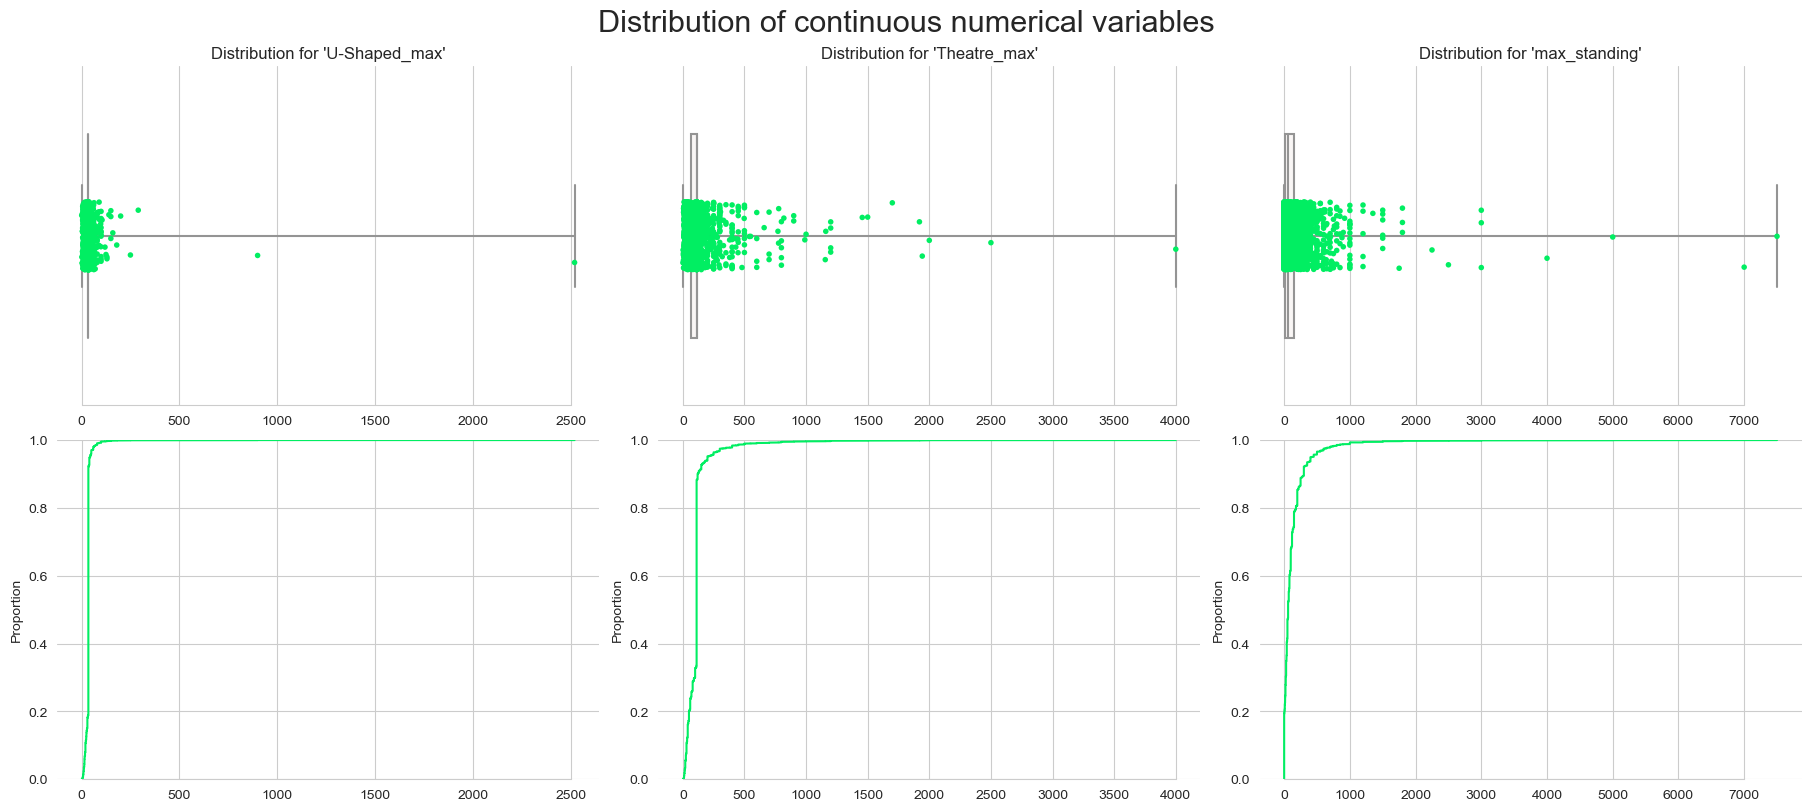

In [9]:
#Distribution of Numerical variables
sns.set_style("whitegrid")
fig , axes = plt.subplots(2,3, figsize=(18, 8),constrained_layout=True, dpi=100)
fig.suptitle('Distribution of continuous numerical variables', fontsize=22)

# Distribution plots for 'U-Shaped_max''.
sns.boxplot(ax= axes[0,0], x='U-Shaped_max', data=df_v0, whis=[0, 100], width=.6, palette="vlag")
sns.stripplot(ax= axes[0,0], x='U-Shaped_max', data=df_v0, size=4, color="#01EE62", linewidth=0)           
sns.ecdfplot(ax= axes[1,0], x='U-Shaped_max',data=df_v0, color="#01EE62")

# Distribution plots for 'Theatre_max'.
sns.boxplot(ax= axes[0,1], x='Theatre_max', data=df_v0, whis=[0, 100], width=.6, palette="vlag")
sns.stripplot(ax= axes[0,1], x='Theatre_max', data=df_v0, size=4, color="#01EE62", linewidth=0)           
sns.ecdfplot(ax= axes[1,1], x='Theatre_max',data=df_v0, color="#01EE62")

# Distribution plots for 'max_standing'.
sns.boxplot(ax= axes[0,2], x='max_standing', data=df_v0, whis=[0, 100], width=.6, palette="vlag")
sns.stripplot(ax= axes[0,2], x='max_standing', data=df_v0, size=4, color="#01EE62", linewidth=0)           
sns.ecdfplot(ax= axes[1,2], x='max_standing',data=df_v0, color="#01EE62")

# Tweak the visual presentation
axes[0,0].set_xlabel("");axes[1,0].set_xlabel("");axes[0,0].set_title("Distribution for 'U-Shaped_max'")
axes[0,1].set_xlabel("");axes[1,1].set_xlabel("");axes[0,1].set_title("Distribution for 'Theatre_max'")
axes[0,2].set_xlabel("");axes[1,2].set_xlabel("");axes[0,2].set_title("Distribution for 'max_standing'")

sns.despine(trim=True, left=True)

<div class="alert alert-block alert-info" style="color:#03162D;border-color:#01EE62;background-color:#DDFFEB; font-size:12px; font-family:verdana; line-height: 1.7em;">
    <b><span style='color:#01EE62'>Observations</span></b> | Outliers

From the previous graph it is noted that we have <b>atypical</b> values that must be removed from the analysis, the criterion to remove them will be to build the <b>empirical cumulative distribution function</b>, In this way we will see what threshold we can define as the maximum value of the variables.

In [10]:
# Defining limits for numeric variables
ecdf_v1 = ECDF(df_v0['U-Shaped_max'])
ecdf_v2 = ECDF(df_v0['Theatre_max'])
ecdf_v3 = ECDF(df_v0['max_standing'])

print('P(x<80): %.3f for U-Shaped_max' % ecdf_v1(80))
print('P(x<550): %.3f for Theatre_max' % ecdf_v2(550))
print('P(x<1000): %.3f for max_standing' % ecdf_v3(1000))


P(x<80): 0.990 for U-Shaped_max
P(x<550): 0.990 for Theatre_max
P(x<1000): 0.993 for max_standing


In [11]:
df_v1 = df_v0[~((df_v0['U-Shaped_max'] > 80)|(df_v0['Theatre_max'] > 550)|(df_v0['max_standing'] > 1000))]

print("Droping values that exceed the treshold")
print("There are {:,} observations and {} columns in the dataset after removing outliers.".format(df_v1.shape[0], df_v1.shape[1]))
print("{} Outliers were droped.".format(df_v0.shape[0] - df_v1.shape[0]))

Droping values that exceed the treshold
There are 3,383 observations and 10 columns in the dataset after removing outliers.
77 Outliers were droped.


<a class="anchor" id="3"></a>
# <div style="color:white;display:fill;border-radius:5px;background-color:#01EE62;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:#03162D;overflow:hidden;margin:0;font-size:110%"><b>3 |</b>  Exploratory Data Analysis</p></div>

In [20]:
# Datasets for ploting

# Analysis for continuous numerical variables

# Plot 1 Number of venues with wheelchair access
plot_df=df_v1.copy()
p1=plot_df['Wheelchair accessible'].value_counts()
p1=p1.rename('count').reset_index().sort_values('count', ascending=False)
x1=p1['index'].apply(lambda x: 'venues with ramp' if x==1 else 'venues without ramp')

# Plot 2 Median number of people standing
p2=plot_df.groupby('Wheelchair accessible')['max_standing'].median().round(0).astype(int)
p2=p2.rename('max_standing').reset_index().sort_values('max_standing', ascending=False)

# Plot 3 Average theater size
p3=plot_df.groupby('Wheelchair accessible')['Theatre_max'].mean().round(0).astype(int)
p3=p3.rename('Theatre_max').reset_index().sort_values('Theatre_max', ascending=False)

# Plot 3 Average theater size
p4=plot_df.groupby('Wheelchair accessible')['U-Shaped_max'].mean().round(0).astype(int)
p4=p4.rename('U-Shaped_max').reset_index().sort_values('U-Shaped_max', ascending=False)

# Ploting -------------------------------------------------------------------------

temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12)))
fig = make_subplots(rows=2, cols=2,
                    vertical_spacing=0.1,
                    subplot_titles=("Number of venues for events with ramps", "Maximum number of people standing", 
                                    "Maximum Average Theater Capacity"," Maximum Average of Width of u-shaped ramp" ))

# Plot 1
fig.add_trace(go.Bar(x=x1, y=p1['count'], text=p1['count'],texttemplate='n = %{text}', textposition='outside',
                     marker=dict(color=['#01EE62', '#7127FF'], opacity=0.8),
                     hovertemplate='Number of %{x} = %{y}<extra></extra>',
                     showlegend=False),row=1,col=1)

# Plot 2
fig.add_trace(go.Bar(x=x1, y=p2['max_standing'], text=p2['max_standing'], textposition='outside',
                     marker=dict(color=['#01EE62', '#7127FF'], opacity=0.8),
                     hovertemplate='Median number of people standing in %{x} = %{y} People<extra></extra>',
                     showlegend=False),row=1,col=2)

# Plot 3
fig.add_trace(go.Bar(x=x1, y=p3['Theatre_max'], text=p3['Theatre_max'], textposition='outside',
                     marker=dict(color=['#01EE62', '#7127FF'], opacity=0.8),
                     hovertemplate='Average theater size in %{x} = %{y}<extra></extra>',
                     showlegend=False),row=2,col=1)

# Plot 4
fig.add_trace(go.Bar(x=x1, y=p4['U-Shaped_max'], text=p4['U-Shaped_max'], textposition='outside',
                     marker=dict(color=['#01EE62', '#7127FF'], opacity=0.8),
                     hovertemplate='Average of Max U-Shaped arrangement in %{x} = %{y}<extra></extra>',
                     showlegend=False),row=2,col=2)


fig.update_traces(marker=dict(line=dict(width=1, color='#000000')))
fig.update_layout(title="Wheelchair Access Statistics (For continuous numerical variables)", title_font_color='#01EE62', 
                  title_font_size = 26, showlegend=True, template=temp, 
                  legend=dict(orientation="h", yanchor="bottom", y=.4, xanchor="right", x=.97),
                  barmode='group', bargap=.15, height=800, width=1300)

fig.show()

In [21]:
# Analysis for binary categorical variables

def plot_df_cat(column = ''):
    plot_df=df_v1.copy()
    p_i=plot_df.groupby(column)['Wheelchair accessible'].value_counts(normalize=True)
    p_i=p_i.mul(100).rename('pct').reset_index()
    x_i=p_i[column].apply(lambda x: 'Yes' if x==1 else 'No').unique()[::-1]
    yi_1=p_i[p_i['Wheelchair accessible']==0]['pct'][::-1]
    yi_2=p_i[p_i['Wheelchair accessible']==1]['pct'][::-1]
    return x_i, yi_1, yi_2

x4, y4_1, y4_2 = plot_df_cat(column = 'Loud music / events')
x5, y5_1, y5_2 = plot_df_cat(column = 'Venue provides alcohol')
x6, y6_1, y6_2 = plot_df_cat(column = 'Wi-Fi')
x7, y7_1, y7_2 = plot_df_cat(column = 'supervenue')
x8, y8_1, y8_2 = plot_df_cat(column = 'Promoted / ticketed events')

temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12)))
fig = make_subplots(rows=3, cols=2,
                    vertical_spacing=0.05,
                    subplot_titles=("Does the event venue allow loud music?", 
                                    "Does the event venue provide alcohol?", 
                                    "Does the event venue have Wi-Fi access?",
                                    "Is the event venue considered a supervenue?",
                                    "Event venue accommodates ticketed events"))

# Plot 4 'Loud music / events'
fig.add_trace(go.Bar(x=x4, y=y4_2, name='venues with ramp', text=y4_2, textposition='outside',
                     texttemplate='%{text:.1f}%', width=0.38, 
                     hovertemplate='Proportion of venues with ramp = %{y:.2f}%<extra></extra>',
                     marker=dict(color='#01EE62', opacity=0.8)), row=1,col=1)
fig.add_trace(go.Bar(x=x4, y=y4_1, name='venues without ramp', text=y4_1, textposition='outside',
                     texttemplate='%{text:.1f}%', width=0.38, 
                     hovertemplate='Proportion of venues without ramp = %{y:.2f}%<extra></extra>',
                     marker=dict(color='#7127FF', opacity=0.8)), row=1,col=1)

# Plot 5 'Venue provides alcohol'
fig.add_trace(go.Bar(x=x5, y=y5_2, name='venues with ramp', text=y5_2, textposition='outside',
                     texttemplate='%{text:.1f}%', width=0.38, showlegend=False,
                     hovertemplate='Proportion of venues with ramp = %{y:.2f}%<extra></extra>',
                     marker=dict(color='#01EE62', opacity=0.8)), row=1,col=2)
fig.add_trace(go.Bar(x=x5, y=y5_1, name='venues without ramp', text=y5_1, textposition='outside',
                     texttemplate='%{text:.1f}%', width=0.38, showlegend=False,
                     hovertemplate='Proportion of venues without ramp = %{y:.2f}%<extra></extra>',
                     marker=dict(color='#7127FF', opacity=0.8)), row=1,col=2)

# Plot 6 'Wi-Fi'
fig.add_trace(go.Bar(x=x6, y=y6_2, name='venues with ramp', text=y6_2, textposition='outside',
                     texttemplate='%{text:.1f}%', width=0.38, showlegend=False,
                     hovertemplate='Proportion of venues with ramp = %{y:.2f}%<extra></extra>',
                     marker=dict(color='#01EE62', opacity=0.8)), row=2,col=1)
fig.add_trace(go.Bar(x=x6, y=y6_1, name='venues without ramp', text=y6_1, textposition='outside',
                     texttemplate='%{text:.1f}%', width=0.38, showlegend=False,
                     hovertemplate='Proportion of venues without ramp = %{y:.2f}%<extra></extra>',
                     marker=dict(color='#7127FF', opacity=0.8)), row=2,col=1)


# Plot 7 'supervenue'
fig.add_trace(go.Bar(x=x7, y=y7_2, name='venues with ramp', text=y7_2, textposition='outside',
                     texttemplate='%{text:.1f}%', width=0.38, showlegend=False,
                     hovertemplate='Proportion of venues with ramp = %{y:.2f}%<extra></extra>',
                     marker=dict(color='#01EE62', opacity=0.8)), row=2,col=2)
fig.add_trace(go.Bar(x=x7, y=y7_1, name='venues without ramp', text=y7_1, textposition='outside',
                     texttemplate='%{text:.1f}%', width=0.38, showlegend=False,
                     hovertemplate='Proportion of venues without ramp = %{y:.2f}%<extra></extra>',
                     marker=dict(color='#7127FF', opacity=0.8)), row=2,col=2)

# Plot 8 'Promoted / ticketed events'
fig.add_trace(go.Bar(x=x8, y=y8_2, name='venues with ramp', text=y8_2, textposition='outside',
                     texttemplate='%{text:.1f}%', width=0.38, showlegend=False,
                     hovertemplate='Proportion of venues with ramp = %{y:.2f}%<extra></extra>',
                     marker=dict(color='#01EE62', opacity=0.8)), row=3,col=1)
fig.add_trace(go.Bar(x=x8, y=y8_1, name='venues without ramp', text=y8_1, textposition='outside',
                     texttemplate='%{text:.1f}%', width=0.38, showlegend=False,
                     hovertemplate='Proportion of venues without ramp = %{y:.2f}%<extra></extra>',
                     marker=dict(color='#7127FF', opacity=0.8)), row=3,col=1)


fig.update_traces(marker=dict(line=dict(width=1, color='#000000')))
fig.update_layout(title="Wheelchair Access Statistics (For binary categorical variables)", title_font_color='#7127FF', title_font_size = 26, showlegend=True, template=temp, 
                  legend=dict(orientation="h", yanchor="top", y=1.055, xanchor="right", x=.85),
                  barmode='group', bargap=.15, height=1100)

fig.update_layout(showlegend=True)

<div class="alert alert-block alert-info" style="color:#03162D;border-color:#01EE62;background-color:#DDFFEB; font-size:12px; font-family:verdana; line-height: 1.7em;">
    <b><span style='color:#01EE62'>Observations</span></b> | Data Distribution

<b><span style='color:#01EE62'>-</span></b> The target variable is relatively balanced with respect to all other variables, that is; having a wheelchair ramp does not have a clear trigger, as it happens and does not happen in the same way in all types of event venues.

    
<b><span style='color:#01EE62'>-</span></b> There are two particular cases, when there is no Wi-Fi, and when the place is considered a supervenue. 
In the case of Wi-Fi, I think it has to do with the comforts that an event venue can offer. If you cannot offer Wi-Fi, perhaps you do not even consider offering access to disabled people. And regarding the classification as a supervenue, I find it curious that although it represents a distinction because it means that this event venue maintains specific performance goals, it does not offer access to a very important part of the population. (almost 10% according to the UN)

In [23]:
fig = make_subplots(rows=3, cols=2, vertical_spacing=0.15,
                    subplot_titles=("Distribution of maximum width of U-shaped ramp<br>by Wheelchair accessibility", "",
                                    "Distribution of the maximum number of people standing<br>by Wheelchair accessibility", "",
                                    "Distribution of the maximum capacity of the theaters <br>by Wheelchair accessibility", ""))

# Distributions for 'U-Shaped_max'-------------------------------------
fig.add_trace(go.Histogram(x=df_v1[df_v1['Wheelchair accessible']==1]['U-Shaped_max'], histnorm='probability density', 
                           marker=dict(color='#01EE62', line=dict(width=1, color='#000000')),
                           opacity=0.8, name='venues with ramp'),
              row=1, col=1)

fig.add_trace(go.Histogram(x=df_v1[df_v1['Wheelchair accessible']==0]['U-Shaped_max'],histnorm='probability density',
                           marker=dict(color='#7127FF', line=dict(width=1, color='#000000')), 
                           opacity=0.7, name='venues without ramp'),
              row=1, col=1)

fig.add_trace(go.Box(y=df_v1[df_v1['Wheelchair accessible']==1]['U-Shaped_max'], name="Wheelchair accessible", 
                     marker_color = '#01EE62', showlegend=False),
              row=1, col=2)
fig.add_trace(go.Box(y=df_v1[df_v1['Wheelchair accessible']==0]['U-Shaped_max'], name="Not Wheelchair Accessible", 
                     marker_color = '#7127FF', showlegend=False), 
              row=1, col=2)

# Distributions for 'max_standing'-------------------------------------

fig.add_trace(go.Histogram(x=df_v1[df_v1['Wheelchair accessible']==1]['max_standing'], histnorm='probability density', 
                           marker=dict(color='#01EE62', line=dict(width=1, color='#000000')),showlegend=False,
                           opacity=0.8, name='venues with ramp'),
              row=2, col=1)

fig.add_trace(go.Histogram(x=df_v1[df_v1['Wheelchair accessible']==0]['max_standing'],histnorm='probability density', 
                           marker=dict(color='#7127FF', line=dict(width=1, color='#000000')),showlegend=False,
                           opacity=0.7, name='venues without ramp'),
              row=2, col=1)

fig.add_trace(go.Box(y=df_v1[df_v1['Wheelchair accessible']==1]['max_standing'], name="Wheelchair accessible", 
                     marker_color = '#01EE62', showlegend=False),
              row=2, col=2)
fig.add_trace(go.Box(y=df_v1[df_v1['Wheelchair accessible']==0]['max_standing'], name="Not Wheelchair Accessible", 
                     marker_color = '#7127FF', showlegend=False), 
              row=2, col=2)


# Distributions for 'Theatre_max'-------------------------------------

fig.add_trace(go.Histogram(x=df_v1[df_v1['Wheelchair accessible']==1]['Theatre_max'], histnorm='probability density', 
                           marker=dict(color='#01EE62', line=dict(width=1, color='#000000')),showlegend=False,
                           opacity=0.8, name='venues with ramp'),
              row=3, col=1)

fig.add_trace(go.Histogram(x=df_v1[df_v1['Wheelchair accessible']==0]['Theatre_max'],histnorm='probability density', 
                           marker=dict(color='#7127FF', line=dict(width=1, color='#000000')),showlegend=False,
                           opacity=0.7, name='venues without ramp'),
              row=3, col=1)

fig.add_trace(go.Box(y=df_v1[df_v1['Wheelchair accessible']==1]['Theatre_max'], name="Wheelchair accessible", 
                     marker_color = '#01EE62', showlegend=False),
              row=3, col=2)
fig.add_trace(go.Box(y=df_v1[df_v1['Wheelchair accessible']==0]['Theatre_max'], name="Not Wheelchair Accessible", 
                     marker_color = '#7127FF', showlegend=False), 
              row=3, col=2)


fig.update_layout(title="Distribution of Continuous Numerical Variables", title_font_color='#01EE62', title_font_size = 26, 
                  xaxis1_title="Max U-shaped width (inches)", yaxis1_title='Probability Density', yaxis2_title='Max U-shaped width (inches)',
                  xaxis3_title="Number of people", yaxis3_title='Probability Density', yaxis4_title='Number of people',
                  xaxis5_title="Teather size", yaxis5_title='Probability Density', yaxis6_title='Teather size',
                  barmode='overlay', showlegend=True, template=temp,
                  legend=dict(orientation="h", yanchor="bottom", y=1.01, xanchor="right", x=.95),
                  height=1300, width=1300)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', zeroline=False)
fig.update_yaxes(showline=False, zeroline=False)
fig.show()

<div class="alert alert-block alert-info" style="color:#03162D;border-color:#01EE62;background-color:#DDFFEB; font-size:12px; font-family:verdana; line-height: 1.7em;">
    <b><span style='color:#01EE62'>Observations</span></b> | Distribution of Numerical Variables
    
Numerical variables have extremely narrow distributions, practically behaving as constant values.

- Regarding the maximum number of people standing, and the maximum capacity of the theater, both are measures of capacity, and in general they only show that theaters have fairly standardized capacities, regardless of whether they have a ramp or not.

In [24]:
# Scatter plots
hd=df_v1["Wheelchair accessible"].apply(lambda x: 'venues with ramp' if x==1 else 'venues without ramp')
fig = px.scatter_matrix(df_v1, 
                        dimensions=["U-Shaped_max", "max_standing", "Theatre_max"],
                        color=hd, color_discrete_sequence=['#01EE62','#7127FF'])
fig.update_traces(marker=dict(line_color='white', size=7, opacity=.7, line_width=0.5), 
                  diagonal_visible=False, showupperhalf=False)
fig.update_layout(title='Numeric Variables Pair Plots', template=temp, 
                  legend=dict(title="",orientation="h", yanchor="bottom", y=.99, xanchor="center", x=.49, 
                              traceorder='reversed'),height=800)
fig.show()

# Correlations
corr=df_v1[["U-Shaped_max", "max_standing", "Theatre_max"]].corr()
x = corr.columns.tolist() 
y = corr.index.tolist()
z = corr.values
text = corr.values.round(2)

fig = ff.create_annotated_heatmap(z=z, x=x, y=y, annotation_text=text, colorscale='Purples_r', 
                                  reversescale=True, showscale=True,
                                  hovertemplate="Correlation of %{x} and %{y}= %{z:.3f}")
fig.update_layout(template=temp, title="Numeric Variables Correlations")
fig.show()


<div class="alert alert-block alert-info" style="color:#03162D;border-color:#01EE62;background-color:#DDFFEB; font-size:12px; font-family:verdana; line-height: 1.7em;">
    <b><span style='color:#01EE62'>Observations</span></b> | Correlation of numerical variables
    
As expected, in the three numerical variables there is a slight linear correlation, although I expected that the capacity correlation would be higher.

Since it doesn't make sense to calculate Pearson's coefficients for binary categorical variables, I used another tool to determine their effect on the existence of wheelchair ramps; **The chi square test**  that allows us to recognize the association between two categorical variables, as is the case with our target variable, and the other binary variables.

In [25]:
# Chi Squared Tests
cat = ['Loud music / events', 'Venue provides alcohol', 'Wi-Fi','supervenue','Promoted / ticketed events']

chi_statistic=[]
p_val=[]
vars_rm=[]

for i in df_v1[cat]:
    observed=pd.crosstab(index=df_v1["Wheelchair accessible"], columns=df_v1[i])
    stat, p, dof, expected=chi2_contingency(observed)
    chi_statistic.append(stat)
    p_val.append(p)
    if p >= 0.05:
        print("Wheelchair accessibility and {} are independent (p-value = {:.2f}).\n".format(i,p))
        vars_rm.append(i)

chi_df = pd.DataFrame(index=cat)
chi_df["Chi Statistic"] = chi_statistic
chi_df["P-value"] = p_val
chi_df=chi_df.sort_values("P-value", ascending=True)
display(chi_df.style.format({"Chi Statistic": "{:.2f}", "P-value": "{:.5f}"}))

Wheelchair accessibility and Loud music / events are independent (p-value = 1.00).



,Chi Statistic,P-value
Promoted / ticketed events,53.19,0.00000
supervenue,37.89,0.00000
Venue provides alcohol,34.28,0.00000
Wi-Fi,20.40,0.00001
Loud music / events,0.00,1.00000


<div class="alert alert-block alert-info" style="color:#03162D;border-color:#01EE62;background-color:#DDFFEB; font-size:12px; font-family:verdana; line-height: 1.7em;">
    <b><span style='color:#01EE62'>Observations</span></b> | Chi Square Test

In the test we find that only one of the variables does not have statistical significance. That a venue allows loud music does not influence at all whether or not it has an access ramp for wheelchairs, which makes a lot of sense. otherwise all other variables have statistical significance with a p-value < 0.05.

# <div style="color:white;display:fill;border-radius:5px;background-color:#01EE62;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:#03162D;overflow:hidden;margin:0;font-size:110%"><b>4 |</b>  Modeling</p></div>

For the modeling I will use 3 of the most used classification algorithms; **Extra Trees Classifier**, **Random Forest Classifier** and **AdaBoost Classifier**

In [ ]:
X = df_v1.drop(columns = ['venue_name', 'Wheelchair accessible'])
y = df_v1['Wheelchair accessible']

# Create training sets
X_train, X2, y_train, y2 = train_test_split(X, y, train_size=0.55, shuffle=True, 
                                            stratify=df_v1['Wheelchair accessible'], random_state=21)

# Create validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X2, y2, test_size=0.5, shuffle=True,
                                                stratify=y2, random_state=21)

# Scale features
scaler=StandardScaler()
X_train=pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val=pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test=pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
print("Train Shape:",X_train.shape)
print("Validation Shape:",X_val.shape)
print("Test Shape:",X_test.shape)

Train Shape: (1860, 8)
Validation Shape: (761, 8)
Test Shape: (762, 8)


## <b><span style='color:#01EE62'>4.1</span> | Extra Trees Classifier</b>

In [ ]:
et=ExtraTreesClassifier(class_weight='balanced', random_state=92)

# Parameter tuning
grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)],
        'criterion':['gini', 'entropy'],
        'max_depth': [5, 10, 15, 20],
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf':  [4, 5, 6]}

et_cv=RandomizedSearchCV(estimator=et, param_distributions=grid, scoring='roc_auc', 
                         n_iter=100, cv=5, random_state=42, n_jobs=-1)
et_cv.fit(X_train, y_train)

# Best estimator
ext=et_cv.best_estimator_

# CV Scores
k_fold = StratifiedKFold(n_splits=8, shuffle=True, random_state=21) 

et_f1_cv=cross_val_score(ext, X_val, y_val, cv=k_fold, scoring='f1', n_jobs=-1)
et_f1 = pd.DataFrame(data={'Score': et_f1_cv, 'Metric': 'F1', 'Model': 'Extra Trees'})
et_acc_cv=cross_val_score(ext, X_val, y_val, cv=k_fold, scoring='accuracy', n_jobs=-1)
et_acc = pd.DataFrame(data={'Score': et_acc_cv, 'Metric': 'Accuracy', 'Model': 'Extra Trees'})
et_df=pd.concat([et_f1, et_acc], axis=0)

print("Grid Search CV Best AUC = {:.3f}\nBest Params: {}".format(et_cv.best_score_, et_cv.best_estimator_))
print()
print("{:.2f}% Accuracy on the validation set with a standard deviation of {:.1f}"\
      .format(et_acc_cv.mean()*100, et_acc_cv.std()*100))
print("{:.2f}% F1-score on the validation set with a standard deviation of {:.1f}"\
      .format(et_f1_cv.mean()*100, et_f1_cv.std()*100))

Grid Search CV Best AUC = 0.687
Best Params: ExtraTreesClassifier(class_weight='balanced', max_depth=20, min_samples_leaf=4,
                     n_estimators=500, random_state=92)

61.37% Accuracy on the validation set with a standard deviation of 5.5
60.76% F1-score on the validation set with a standard deviation of 5.0


## <b><span style='color:#01EE62'>4.2</span> | Random Forest Classifier</b>

In [ ]:
rf=RandomForestClassifier(class_weight='balanced', random_state=92)

# Parameter tuning
grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)],
        'criterion':['gini', 'entropy'],
        'max_depth': [3, 7, 14, 21],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf':  [3, 5, 7],
        'max_features': [None, 'sqrt'],
        'max_leaf_nodes': [None, 5, 10, 15, 20],
        'min_impurity_decrease': [0.001, 0.01, 0.05, 0.1],
        'bootstrap': [True, False]}

rf_cv=RandomizedSearchCV(estimator=rf, param_distributions=grid, scoring='roc_auc', 
                         n_iter=100, cv=5, random_state=42, n_jobs=-1)
rf_cv.fit(X_train, y_train)

# Best estimator
rf=rf_cv.best_estimator_

# CV Scores
rf_f1_cv=cross_val_score(rf, X_val, y_val, cv=k_fold, scoring='f1', n_jobs=-1)
rf_f1 = pd.DataFrame(data={'Score': rf_f1_cv, 'Metric': 'F1', 'Model': 'Random Forest'})
rf_acc_cv=cross_val_score(rf, X_val, y_val, cv=k_fold, scoring='accuracy', n_jobs=-1)
rf_acc = pd.DataFrame(data={'Score': rf_acc_cv, 'Metric': 'Accuracy', 'Model': 'Random Forest'})
rf_df=pd.concat([rf_f1, rf_acc], axis=0)

print("Grid Search CV Best AUC = {:.3f}\nBest Params: {}".format(rf_cv.best_score_, rf_cv.best_estimator_))
print()
print("{:.2f}% Accuracy on the validation set with a standard deviation of {:.1f}"\
      .format(rf_acc_cv.mean()*100, rf_acc_cv.std()*100))
print("{:.2f}% F1-score on the validation with set a standard deviation of {:.1f}"\
      .format(rf_f1_cv.mean()*100, rf_f1_cv.std()*100))

Grid Search CV Best AUC = 0.701
Best Params: RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=7, max_features='sqrt', max_leaf_nodes=20,
                       min_impurity_decrease=0.001, min_samples_leaf=3,
                       min_samples_split=5, n_estimators=300, random_state=92)

62.04% Accuracy on the validation set with a standard deviation of 5.8
59.76% F1-score on the validation with set a standard deviation of 5.8


## <b><span style='color:#01EE62'>4.3</span> | AdaBoost Classifier</b>

In [ ]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, class_weight='balanced'), random_state=92)

# Parameter tuning
grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)],
        'learning_rate': [0.25, 0.5, 0.75, 0.9]}

ada_cv=RandomizedSearchCV(estimator=ada, param_distributions=grid, scoring='roc_auc', 
                          n_iter=20, cv=5, random_state=92, n_jobs=-1, error_score='raise')

ada_cv.fit(X_train, y_train)

# Best estimator
ada = ada_cv.best_estimator_

# CV Scores
ada_f1_cv=cross_val_score(ada, X_val, y_val, cv=k_fold, scoring='f1', n_jobs=-1)
ada_f1 = pd.DataFrame(data={'Score': ada_f1_cv, 'Metric': 'F1', 'Model': 'AdaBoost'})
ada_acc_cv=cross_val_score(ada, X_val, y_val, cv=k_fold, scoring='accuracy', n_jobs=-1)
ada_acc = pd.DataFrame(data={'Score': ada_acc_cv, 'Metric': 'Accuracy', 'Model': 'AdaBoost'})
ada_df=pd.concat([ada_f1, ada_acc], axis=0)

print("Grid Search CV Best AUC = {:.3f}\nBest Params: {}".format(ada_cv.best_score_, ada_cv.best_estimator_))
print()
print("{:.2f}% accuracy on the validation set with a standard deviation of {:.1f}"\
      .format(ada_acc_cv.mean()*100, ada_acc_cv.std()*100))
print("{:.2f}% F1-score on the validation set with a standard deviation of {:.1f}"\
      .format(ada_f1_cv.mean()*100, ada_f1_cv.std()*100))

Grid Search CV Best AUC = 0.704
Best Params: AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=1),
                   learning_rate=0.25, n_estimators=100, random_state=92)

62.56% accuracy on the validation set with a standard deviation of 5.9
61.70% F1-score on the validation set with a standard deviation of 5.6


<div class="alert alert-block alert-info" style="color:#03162D;border-color:#01EE62;background-color:#DDFFEB; font-size:12px; font-family:verdana; line-height: 1.7em;">
    <b><span style='color:#01EE62'>Observations</span></b> | Classification models

The three models have very similar performances, although **AdaBoost** is slightly better, as it has the largest area under the curve and an average accuracy of 62.56%, which complies with what was requested by our manager, since *it correctly predicts at least two thirds of the events in where an event venue has a wheelchair ramp*.

# <div style="color:white;display:fill;border-radius:5px;background-color:#01EE62;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:110%"><b>5 |</b> Model Comparison</p></div>
## <b><span style='color:#01EE62'>5.1</span> | Model Performance on the Validation Set</b>

In [ ]:
plot_df=pd.concat([et_df, rf_df, ada_df], axis=0)
plot_df['Score']=plot_df.Score.mul(100)
fig = px.box(plot_df, x="Model", y="Score", color="Metric", 
             title="Model Performance on the Validation Set",
             color_discrete_sequence = ['#01EE62','#7127FF'])
fig.update_layout(template=temp, xaxis_title='Model', yaxis_ticksuffix='%')
fig.update_xaxes(categoryorder='median descending')
fig.show()

<div class="alert alert-block alert-info" style="color:#03162D;border-color:#01EE62;background-color:#DDFFEB; font-size:12px; font-family:verdana; line-height: 1.7em;">
    <b><span style='color:#01EE62'>Observations</span></b> | Performance

Comparing the cross-validation results in the boxplots above, we see the **AdaBoost** model produces the highest median F1-score of 64.21% and the highest median accuracy of 63.68%.

## <b><span style='color:#01EE62'>5.2</span> | Model Performance on the Test Set</b>

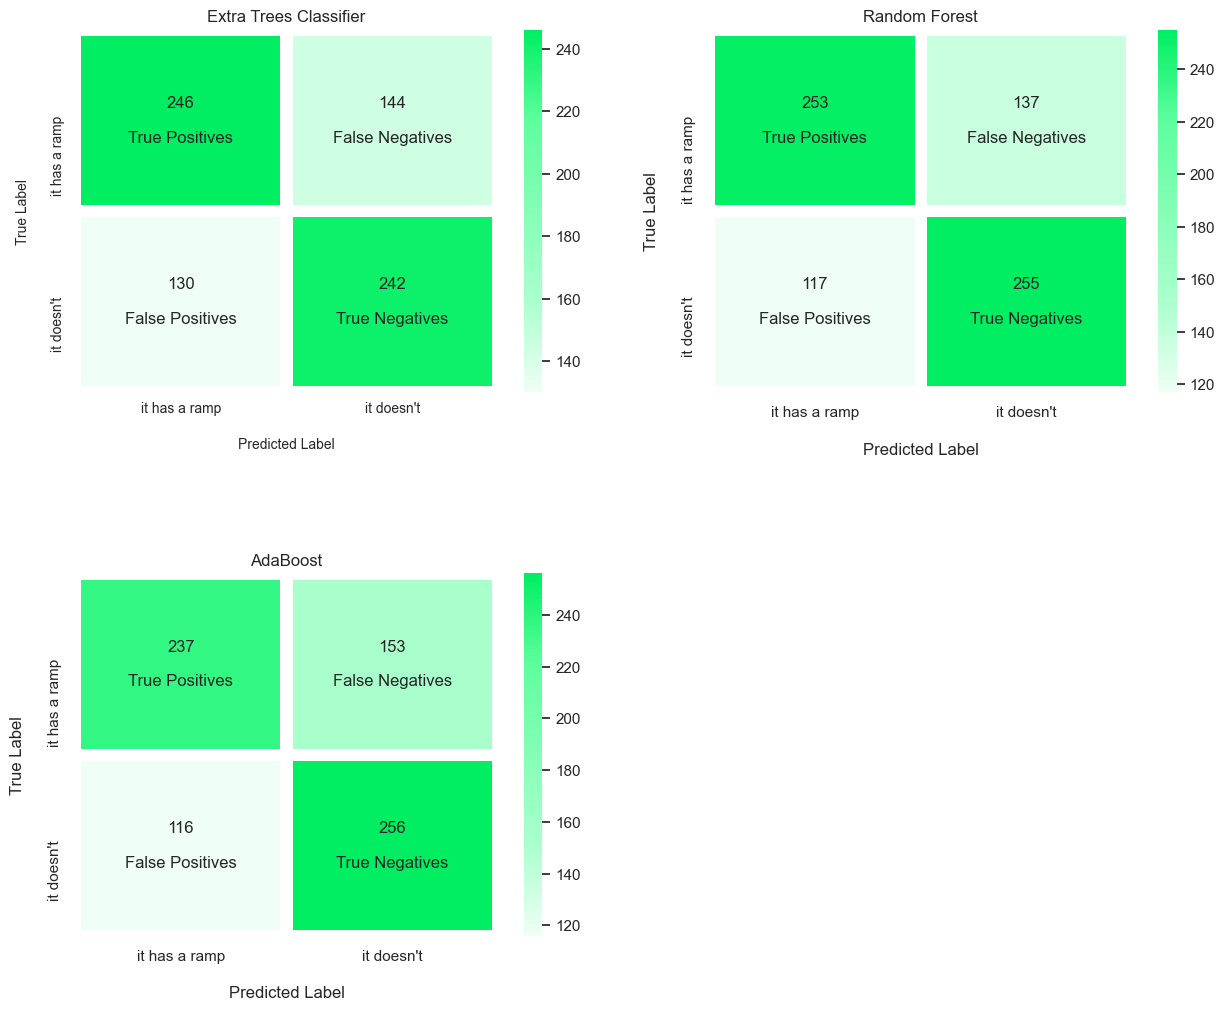

In [ ]:
datacamp=LinearSegmentedColormap.from_list('datacamp', 
                                        [(0, '#EFFFF5'), 
                                        (0.25, '#ABFFCD'),
                                        (.75, '#5EFE9F'), 
                                        (1, '#01EE62')], N=256)

# Confusion Matrix
models={"Extra Trees Classifier":ext, "Random Forest": rf, "AdaBoost": ada}
        
plt.figure(figsize=(15, 12), dpi=100)
plt.subplots_adjust(hspace=0.5)

for i, mod in enumerate(models.items()):
    ax = plt.subplot(2, 2, i+1)
    m=list(models.values())[i]
    y_preds=m.predict(X_test)
    cm = confusion_matrix(y_test, y_preds, labels=[1,0])
    classes=["it has a ramp","it doesn't"]
    label = ['True Positives', 'False Negatives', 'False Positives', 'True Negatives']
    annot = [f'{i}\n\n{j}' for i, j in zip(cm.flatten(), label)]
    annot = np.asarray(annot).reshape(2,2)

    sns.set_context('notebook') 
    ax = sns.heatmap(cm, annot=annot, fmt='', cmap=datacamp, linecolor='white', linewidths=8)
    ax.set_title(list(models.keys())[i])
    ax.set_xlabel('\nPredicted Label')
    ax.set_ylabel('True Label\n')
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)

<div class="alert alert-block alert-info" style="color:#03162D;border-color:#01EE62;background-color:#DDFFEB; font-size:12px; font-family:verdana; line-height: 1.7em;">
    <b><span style='color:#01EE62'>Observations</span></b> | Performance in the test set

The confusion matrices for the predictions made on the test set show a slight change in performance; the Random Forest model classified the highest amount of True Positives (Event venues with a wheelchair ramp), as well as the highest amount of True Negative (Event venues without a wheelchair ramp).
    
This is expected since in general the 3 models have similar performances, (although AdaBoost and Random Forest are closer to each other in terms of performance)

# <div style="color:white;display:fill;border-radius:5px;background-color:#01EE62;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:110%"><b>6 |</b> ROC Curves</p></div>

In [ ]:
# ROC Curves
fpr = {}
tpr = {}
roc_auc = {}
thresh = {}

models=[ext, rf, ada]
    
for i in range(len(models)):
    m=models[i]
    y_probs=m.predict_proba(X_test)
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_probs[:,1], pos_label=1)
    roc_auc[i] = cross_val_score(m, X_test, y_test, cv=k_fold, 
                                 scoring='roc_auc', n_jobs=-1).mean()

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr[0], y=tpr[0], line=dict(color='#ABFFCD', width=2.5), opacity=0.7,
                         hovertemplate = 'Extra Trees True positive rate = %{y:.3f}, False positive rate = %{x:.3f}<extra></extra>',
                         name='Extra Trees ROC Curve (AUC = {:.3f})'.format(roc_auc[0])))
fig.add_trace(go.Scatter(x=fpr[1], y=tpr[1], line=dict(color='#7127FF', width=2.5), opacity=0.7,
                         hovertemplate = 'Random Forest True positive rate = %{y:.3f}, False positive rate = %{x:.3f}<extra></extra>',
                         name='Random Forest ROC Curve (AUC = {:.3f})'.format(roc_auc[1])))
fig.add_trace(go.Scatter(x=fpr[2], y=tpr[2], line=dict(color='#01EE62', width=2.5), opacity=0.7,
                         hovertemplate = 'AdaBoost True positive rate = %{y:.3f}, False positive rate = %{x:.3f}<extra></extra>',
                         name='AdaBoost ROC Curve (AUC = {:.3f})'.format(roc_auc[2])))

fig.add_shape(type="line", xref="x", yref="y", x0=0, y0=0, x1=1, y1=1, 
              line=dict(color="Black", width=1, dash="dot"))

fig.update_layout(template=temp, title="ROC Curve Comparison on the Test Set", hovermode="x unified", 
                  hoverlabel = dict(bgcolor="white",font_size=12), xaxis=dict(hoverformat=".2f"),
                  xaxis_title='False Positive Rate (1 - Specificity)', yaxis_title='True Positive Rate (Sensitivity)', 
                  legend=dict(y=.12, x=1, xanchor="right",bordercolor="black",borderwidth=.5, font=dict(size=14)),
                  height=600, width=700)
fig.show()

<div class="alert alert-block alert-info" style="color:#03162D;border-color:#01EE62;background-color:#DDFFEB; font-size:12px; font-family:verdana; line-height: 1.7em;">
    <b><span style='color:#01EE62'>Observations</span></b> | ROC Curves 

A model with a curve near the top left of the graph, with a higher true positive rate and a lower false positive rate, indicates a better capability to distinguish between the classes. In the plot above, all of the models produce strong results on the test set. but Random Forest provides the highest Area Under the Curve overall at 0.693.

# <div style="color:white;display:fill;border-radius:5px;background-color:#01EE62;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:110%"><b>7 |</b> Conclusion</p></div>

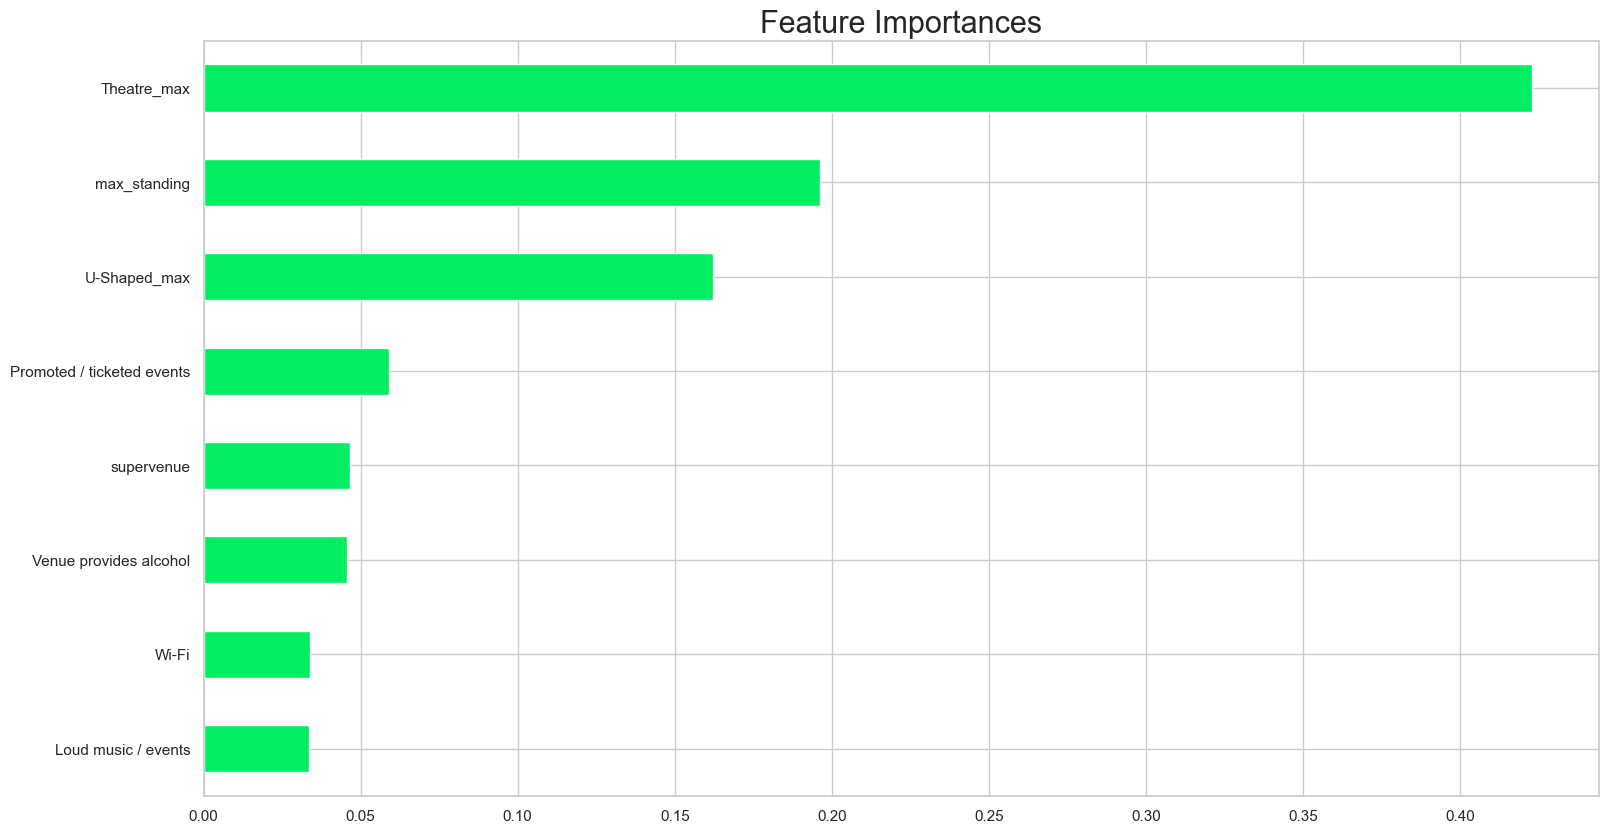

In [ ]:
plt.figure(figsize=(18, 10), dpi=100)
feat_importances = pd.Series(rf.feature_importances_, index=X_test.columns).sort_values()
feat_importances.plot(kind='barh', color='#01EE62')

plt.title("Feature Importances", fontdict={'fontsize':22});

After making an in-depth analysis of the variables related to whether an event venue has a wheelchair ramp or not, we built and adjusted different classification models with the aim of predicting the existence of this ramp, among which the AdaBoost and Random Forest models stood out. both meet the performance requested by our manager.
In the exploratory data analysis it was very difficult to identify which variable had an important effect on the target variable, but after building the model and plotting the importance of the variables, we can see that in the end the most important variables are the capacity of the venue which makes a lot of sense, the more people can receive a place, the more likely that among them there are disabled people who need special access, it is important to remember that they represent 10% of the population and their needs are also important.

## <b><span style='color:#01EE62'>7.1</span> | References</b>

>
> - [The Supervenue Program](https://www.tagvenue.com/page/terms-super-venue#:~:text=The%20Supervenue%20Program%20provides%20benefits,Supervenue%20status%20within%2048%20hours.)
>
>- [NACIONES UNIDAS- Personas con Discapacidad](https://www.tagvenue.com/page/terms-super-venue#:~:text=The%20Supervenue%20Program%20provides%20benefits,Supervenue%20status%20within%2048%20hours.)
>
>- [How to Build a Wheelchair Ramp](https://spinalcordinjuryzone.com/info/11143/how-to-build-a-wheelchair-ramp#:~:text=Ramps%20that%20are%20used%20for,inches%20to%20accommodate%20a%20wheelchair.)
>
>- [Heart Disease Predictions with Shapley](https://www.kaggle.com/code/kellibelcher/heart-disease-predictions-with-shapley)